In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import random
from importnb import Notebook
import config  # Your configuration
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Subset
import pandas as pd
from tqdm.auto import tqdm
import models  # Your models.py, which should import from diamond_models
import glob
from dataclasses import dataclass # Re-define dataclasses if not in models.py
from typing import List, Optional, Dict, Any # Re-define if not in models.py

# Ensure diamond_models & jetbot_dataset can be imported
try:
    with Notebook():
        from jetbot_dataset import JetbotDataset, display_dataset_entry, load_train_test_split, filter_dataset_by_action
    print("JetbotDataset imported successfully.")
except Exception as e:
    print(f"Error importing JetbotDataset: {e}")
    print("Please ensure jetbot_dataset.py and its dependencies (like importnb) are available.")
    # You might need to add the path:
    # import sys
    # sys.path.append('path_to_your_notebooks')


JetbotDataset imported successfully.


In [2]:
print("--- Configuration ---")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load relevant parameters from config (ensure these match training)
DM_IMG_CHANNELS = getattr(config, 'DM_IMG_CHANNELS', 3)
DM_NUM_STEPS_CONDITIONING = getattr(config, 'DM_NUM_STEPS_CONDITIONING', config.NUM_PREV_FRAMES)
DM_COND_CHANNELS = getattr(config, 'DM_COND_CHANNELS', 256)
DM_UNET_DEPTHS = getattr(config, 'DM_UNET_DEPTHS', [2, 2, 2, 2])
DM_UNET_CHANNELS = getattr(config, 'DM_UNET_CHANNELS', [128, 256, 512, 1024])
DM_UNET_ATTN_DEPTHS = getattr(config, 'DM_UNET_ATTN_DEPTHS', [False, False, True, True])
DM_NUM_ACTIONS = getattr(config, 'DM_NUM_ACTIONS', 2)
DM_IS_UPSAMPLER = getattr(config, 'DM_IS_UPSAMPLER', False)
DM_UPSAMPLING_FACTOR = getattr(config, 'DM_UPSAMPLING_FACTOR', None)
DM_SIGMA_DATA = getattr(config, 'DM_SIGMA_DATA', 0.5)
DM_SIGMA_OFFSET_NOISE = getattr(config, 'DM_SIGMA_OFFSET_NOISE', 0.1)
DM_NOISE_PREVIOUS_OBS = getattr(config, 'DM_NOISE_PREVIOUS_OBS', True)

SAMPLER_NUM_STEPS = getattr(config, 'SAMPLER_NUM_STEPS', 50)
SAMPLER_SIGMA_MIN = getattr(config, 'SAMPLER_SIGMA_MIN', 0.002)
SAMPLER_SIGMA_MAX = getattr(config, 'SAMPLER_SIGMA_MAX', 80.0)
SAMPLER_RHO = getattr(config, 'SAMPLER_RHO', 7.0)
SAMPLER_ORDER = getattr(config, 'SAMPLER_ORDER', 1)
SAMPLER_S_CHURN = getattr(config, 'SAMPLER_S_CHURN', 0.0)


--- Configuration ---
Using device: cuda


In [3]:
print("--- Loading Model ---")
checkpoint_to_load = None
denoiser = None
diffusion_sampler = None

# Find the best checkpoint (or fallback)
best_checkpoint_path = os.path.join(config.CHECKPOINT_DIR, "denoiser_model_best_train_loss.pth")
latest_checkpoints = glob.glob(os.path.join(config.CHECKPOINT_DIR, 'denoiser_model_epoch_*.pth'))

if os.path.exists(best_checkpoint_path):
    checkpoint_to_load = best_checkpoint_path
    print(f"Found best model checkpoint: {checkpoint_to_load}")
elif config.LOAD_CHECKPOINT and os.path.exists(config.LOAD_CHECKPOINT):
    checkpoint_to_load = config.LOAD_CHECKPOINT
    print(f"Using specific checkpoint from config: {checkpoint_to_load}")
elif latest_checkpoints:
    latest_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
    checkpoint_to_load = latest_checkpoints[0]
    print(f"Using latest epoch checkpoint: {checkpoint_to_load}")
else:
    print("ERROR: No suitable checkpoint found. Cannot run test.")

if checkpoint_to_load:
    try:
        print(f"Loading checkpoint: {checkpoint_to_load}")
        checkpoint = torch.load(checkpoint_to_load, map_location=DEVICE)

        # 1. Instantiate InnerModel (using current config - MUST match training)
        inner_model_config = models.InnerModelConfig(
            img_channels=DM_IMG_CHANNELS,
            num_steps_conditioning=DM_NUM_STEPS_CONDITIONING,
            cond_channels=DM_COND_CHANNELS,
            depths=DM_UNET_DEPTHS,
            channels=DM_UNET_CHANNELS,
            attn_depths=DM_UNET_ATTN_DEPTHS,
            num_actions=DM_NUM_ACTIONS,
            is_upsampler=DM_IS_UPSAMPLER
        )
        # Check if InnerModel or InnerModelImpl is used
        InnerModelClass = getattr(models, 'InnerModel', getattr(models, 'InnerModelImpl', None))
        if InnerModelClass is None: raise ValueError("Could not find InnerModel or InnerModelImpl in models.py")
        inner_model_instance = InnerModelClass(inner_model_config) # Don't move to DEVICE yet

        # 2. Instantiate Denoiser
        denoiser_cfg = models.DenoiserConfig(
            inner_model=inner_model_config, # Pass config
            sigma_data=DM_SIGMA_DATA,
            sigma_offset_noise=DM_SIGMA_OFFSET_NOISE,
            noise_previous_obs=DM_NOISE_PREVIOUS_OBS,
            upsampling_factor=DM_UPSAMPLING_FACTOR,
        )
        denoiser = models.Denoiser(cfg=denoiser_cfg).to(DEVICE)

        # 3. Load State Dict
        denoiser.load_state_dict(checkpoint['model_state_dict'])
        loaded_epoch = checkpoint.get('epoch', 'N/A')
        print(f"Successfully loaded model state from epoch {loaded_epoch}.")
        denoiser.eval()

        # 4. Instantiate DiffusionSampler
        sampler_cfg = models.DiffusionSamplerConfig(
            num_steps_denoising=SAMPLER_NUM_STEPS,
            sigma_min=SAMPLER_SIGMA_MIN,
            sigma_max=SAMPLER_SIGMA_MAX,
            rho=SAMPLER_RHO,
            order=SAMPLER_ORDER,
            s_churn=SAMPLER_S_CHURN,
        )
        diffusion_sampler = models.DiffusionSampler(
            denoiser=denoiser,
            cfg=sampler_cfg
        )
        print("DiffusionSampler created.")

    except Exception as e:
        print(f"Error loading checkpoint or instantiating model: {e}")
        denoiser = None
        diffusion_sampler = None

if denoiser is None:
    print("Model loading failed. Notebook execution stopped.")
    assert False, "Model loading failed."


--- Loading Model ---
Found best model checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\checkpoints\denoiser_model_best_train_loss.pth
Loading checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\checkpoints\denoiser_model_best_train_loss.pth
Successfully loaded model state from epoch 196.
DiffusionSampler created.


In [4]:
print("--- Loading Dataset ---")
full_dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=config.IMAGE_SIZE,
    num_prev_frames=config.NUM_PREV_FRAMES,
    transform=config.TRANSFORM
)

split_file_path = os.path.join(config.OUTPUT_DIR, getattr(config, 'SPLIT_DATASET_FILENAME', 'dataset_split.pth'))

train_dataset, test_dataset = load_train_test_split(dataset=full_dataset, filename=split_file_path)

if test_dataset is None:
    print("Error: Could not load test dataset split. Trying to create one.")
    total_size = len(full_dataset)
    train_size = int(total_size * 0.9)
    val_size = total_size - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size])
    assert test_dataset is not None, "Failed to load or create test_dataset."

print(f"Using test dataset split with {len(test_dataset)} samples.")

# Create a DataLoader for the test set (batch_size=1 for evaluation)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)


--- Loading Dataset ---
Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Using test dataset split with 11 samples.


In [5]:
split_file_path
print(len(full_dataset))
print(len(train_dataset))
print(len(test_dataset))

3803
13
11


In [6]:
def tensor_to_pil(tensor_img):
    """Converts a [-1, 1] tensor to a PIL Image."""
    tensor_img = (tensor_img.clamp(-1, 1) + 1) / 2
    tensor_img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    if tensor_img.shape[2] == 1:
        tensor_img = tensor_img.squeeze(2)
    pil_img_array = (tensor_img * 255).astype(np.uint8)
    pil_img = Image.fromarray(pil_img_array)
    return pil_img

def display_frame_pil(pil_frame, ax, title=None):
    """Displays a PIL Image on a matplotlib Axes object."""
    ax.imshow(pil_frame)
    ax.axis('off')
    if title:
        ax.set_title(title)

In [7]:
def test_multistep_prediction_diamond(
    sampler,
    initial_current_tensor,   # Starting frame (image_t) as Tensor (1, C, H, W)
    initial_prev_frames_tensor,# Stack of prev frames (image_{t-N} to image_{t-1}) as Tensor (1, N*C, H, W)
    actions,                  # Tensor of *future* actions (shape: (n, 1))
    device,
    output_dir,
    display=True
):
    """
    Tests multi-step prediction using the DiffusionSampler.
    """
    sampler.denoiser.eval()
    num_steps = actions.shape[0]
    predicted_frames_pil = [] # Will store PIL Images

    # Constants
    B = 1 # We process one sequence at a time
    N = config.NUM_PREV_FRAMES
    C = DM_IMG_CHANNELS
    H = config.IMAGE_SIZE
    W = config.IMAGE_SIZE

    # --- Prepare initial state ---
    current_frame_tensor = initial_current_tensor.to(device)
    # Reshape initial prev_frames_tensor to 5D: (1, N, C, H, W)
    current_prev_frames_5d = initial_prev_frames_tensor.view(B, N, C, H, W).to(device)

    # We need a sequence of N actions for the *first* prediction.
    # We only have *future* actions. We need past actions or make an assumption.
    # For visualization, we'll assume the action that *led* to the initial_current_tensor
    # was the *first* action in the provided `actions` list, and tile it.
    # This is a simplification! A better approach would be to get action history.
    initial_action = actions[0].item()
    current_action_seq = torch.full((B, N), initial_action, dtype=torch.long, device=device)

    initial_frame_pil = tensor_to_pil(current_frame_tensor[0])
    
    print(f"Starting multi-step prediction for {num_steps} steps...")
    start_time = time.time()

    with torch.no_grad():
        for step in range(num_steps):
            action_for_this_step = actions[step].item() # The *future* action (a_t, a_{t+1}, ...)
            
            # Update the action sequence: roll in the new action
            current_action_seq = torch.cat(
                [current_action_seq[:, 1:], torch.tensor([[action_for_this_step]], dtype=torch.long, device=device)], 
                dim=1
            )

            # Predict frame t+1 using frames {t-N+1...t} and actions {t-N+1...t}
            predicted_frame_tensor, _ = sampler.sample(
                prev_obs=current_prev_frames_5d, # Expects (B, N, C, H, W)
                prev_act=current_action_seq    # Expects (B, N)
            )

            # Store PIL image
            predicted_frames_pil.append(tensor_to_pil(predicted_frame_tensor[0]))

            # Update State for the *Next* Prediction Step
            # New prev_frames_5d is [x_{t-N+2}, ..., x_t, x_{t+1}]
            current_prev_frames_5d = torch.cat(
                [current_prev_frames_5d[:, 1:, :, :, :], predicted_frame_tensor.unsqueeze(1)], 
                dim=1
            )

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Generated {num_steps} frames in {total_time:.4f} seconds ({total_time / num_steps:.4f} s/frame)")

    # Display
    if display:
        num_cols = num_steps + 1
        fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 3.5))
        if num_cols == 1: axes = [axes] # Ensure axes is indexable

        display_frame_pil(initial_frame_pil, axes[0], title="Initial Frame (t)")

        for i, frame in enumerate(predicted_frames_pil):
            display_frame_pil(frame, axes[i + 1], title=f"Pred (t+{i+1})\nAction: {actions[i].item():.2f}")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(f"Multi-step Prediction (Epoch {loaded_epoch})", fontsize=16)
        
        # Save figure
        save_path = os.path.join(output_dir, f"multistep_pred_epoch_{loaded_epoch}.png")
        plt.savefig(save_path)
        print(f"Saved multi-step prediction plot to {save_path}")
        
        plt.show()

    return predicted_frames_pil

In [8]:
def random_multistep(target_dataset):
    entry_idx = random.randint(0, len(target_dataset) - 1)
    current_tensor, action_tensor, prev_frames_tensor = target_dataset[entry_idx]
    print(f'Initial State {entry_idx}:')
    display_dataset_entry((current_tensor, action_tensor, prev_frames_tensor))

    # Define future actions (e.g., continue straight, then turn)
    num_vis_steps = 5
    # vis_actions = torch.tensor([[0.1]] * 3 + [[0.0]] * 2, dtype=torch.float32) 
    vis_actions = torch.tensor([[0.1]] * num_vis_steps, dtype=torch.float32) # Go straight for 5 steps

    # Run prediction
    predicted_pil_frames = test_multistep_prediction_diamond(
        diffusion_sampler,
        current_tensor.unsqueeze(0),
        prev_frames_tensor.unsqueeze(0),
        vis_actions,
        DEVICE,
        config.TEST_SAMPLE_DIR, # Save plot to test_samples dir
        display=True
    )    

In [9]:
dataset_00 = filter_dataset_by_action(full_dataset, 0.0)

Filtering dataset with 3803 samples for actions: [0.0]


Filtering Dataset:   0%|          | 0/3803 [00:00<?, ?it/s]

Filtered down to 2006 samples.


Initial State 1210:


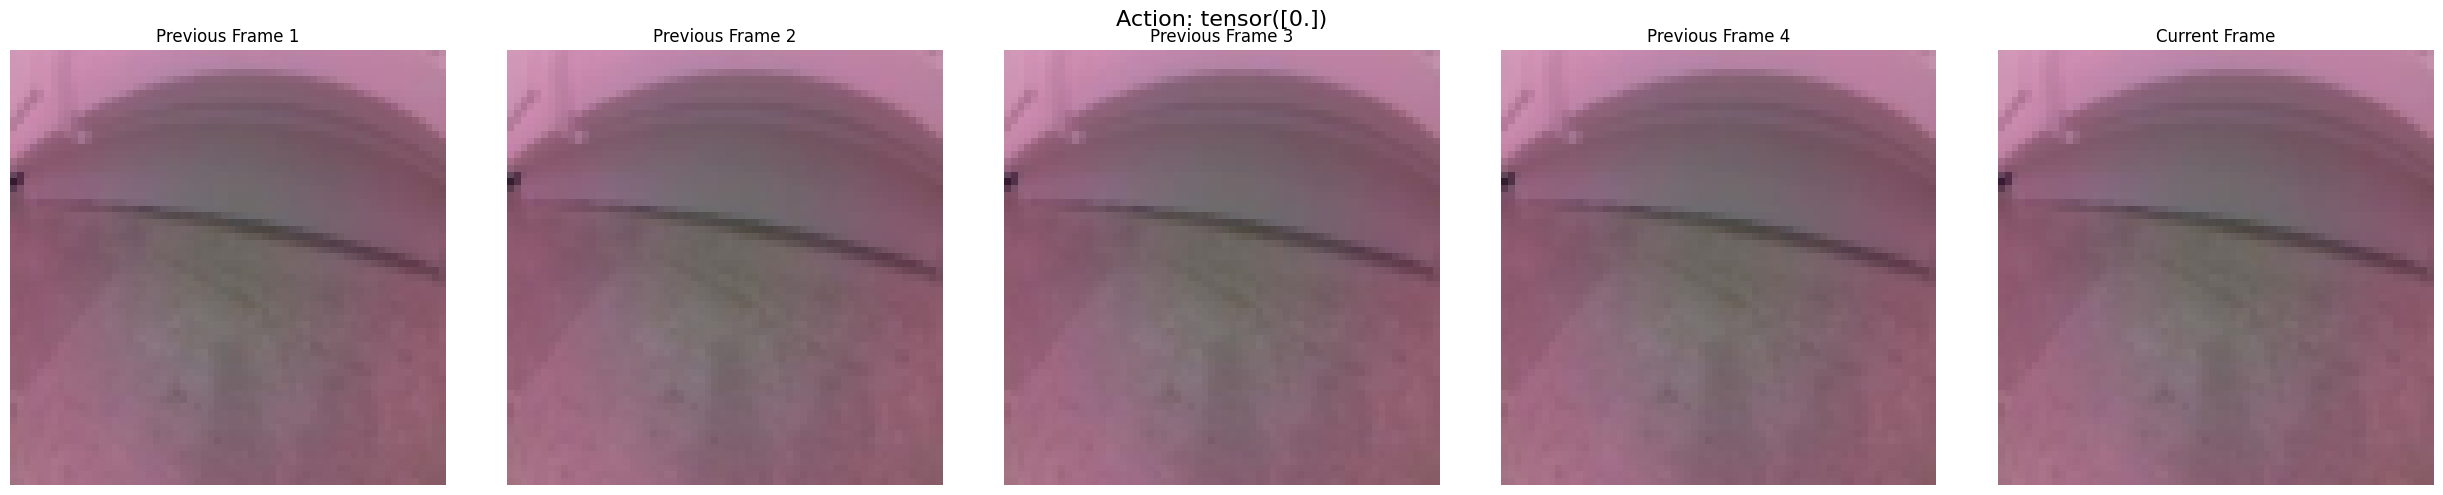

Starting multi-step prediction for 5 steps...
Generated 5 frames in 5.7570 seconds (1.1514 s/frame)
Saved multi-step prediction plot to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\test_samples\multistep_pred_epoch_196.png


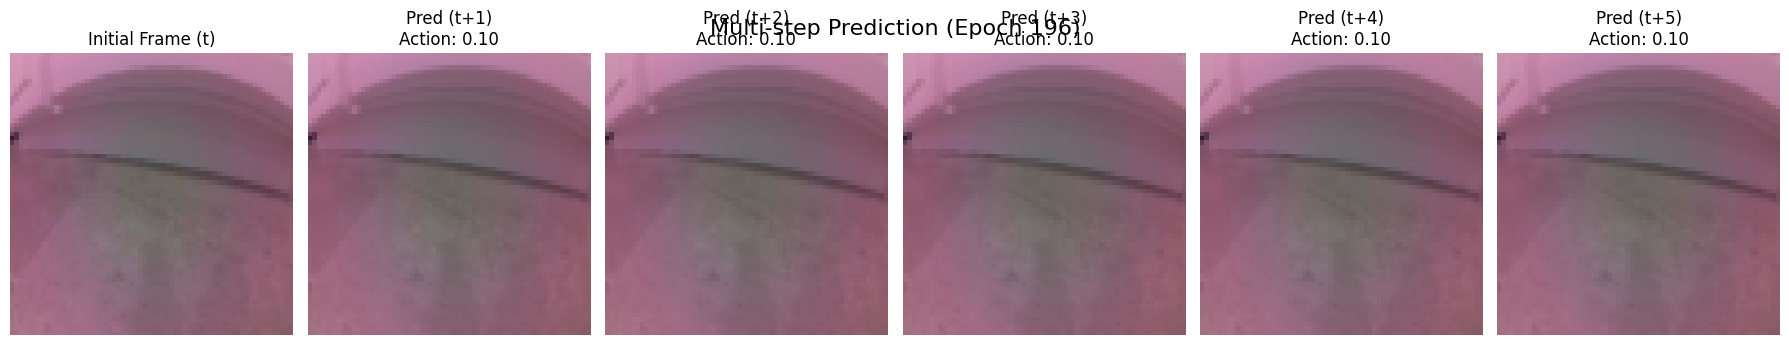

In [15]:
random_multistep(dataset_00)

--- Running Qualitative Multi-step Prediction ---
Filtering dataset with 3803 samples for actions: [0.1]


Filtering Dataset:   0%|          | 0/3803 [00:00<?, ?it/s]

Filtered down to 1797 samples.
Using sample 1697 from action=0.1 subset.
Initial State:


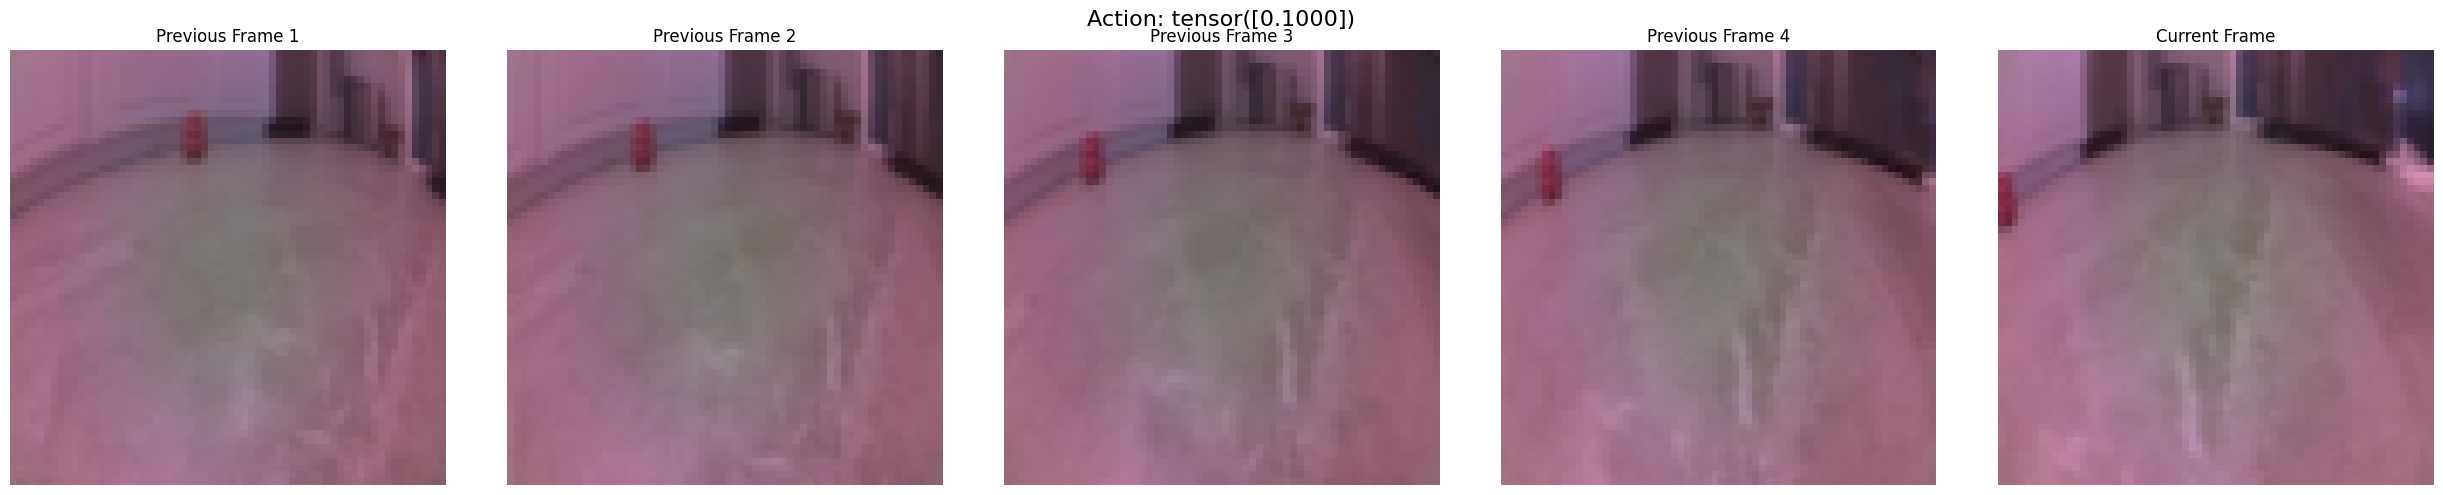

Starting multi-step prediction for 5 steps...
Generated 5 frames in 8.4011 seconds (1.6802 s/frame)
Saved multi-step prediction plot to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND\test_samples\multistep_pred_epoch_196.png


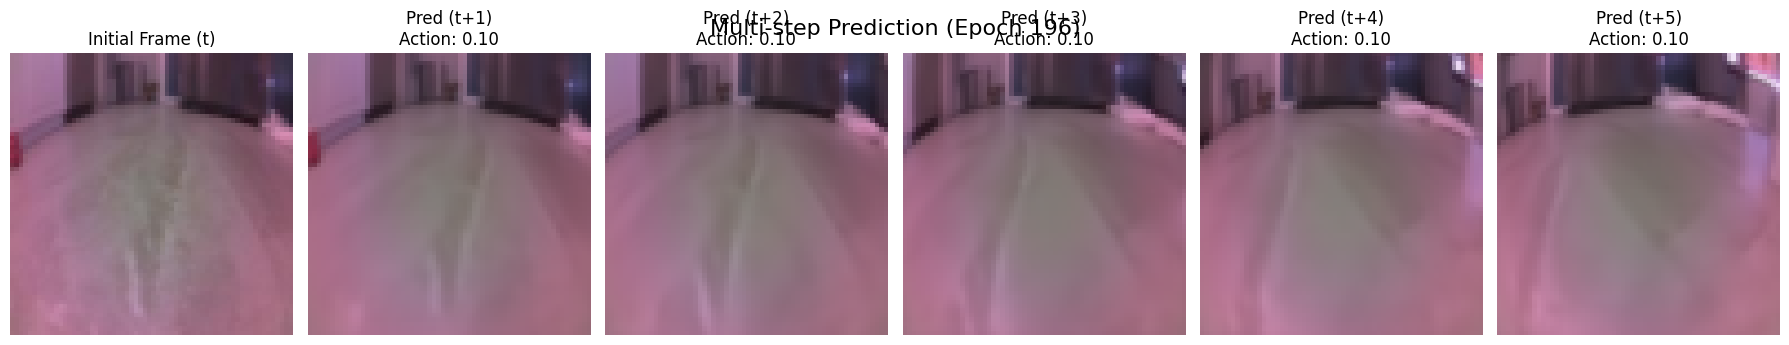

In [8]:
print("--- Running Qualitative Multi-step Prediction ---")

# Find an example - maybe one that goes straight for a bit?
# Or just a random one.
try:
    target_action_qual = 0.1 # Try to find one going mostly straight
    dataset_01 = filter_dataset_by_action(full_dataset, target_action_qual)
    
    if len(dataset_01) > 0:
        entry_idx = random.randint(0, len(dataset_01) - 1)
        current_tensor, action_tensor, prev_frames_tensor = dataset_01[entry_idx]
        print(f"Using sample {entry_idx} from action={target_action_qual} subset.")
    else:
        print(f"No samples found for action {target_action_qual}. Using random sample.")
        entry_idx = random.randint(0, len(test_dataset) - 1)
        current_tensor, action_tensor, prev_frames_tensor = test_dataset[entry_idx]

    # Display the starting point
    print("Initial State:")
    display_dataset_entry((current_tensor, action_tensor, prev_frames_tensor))

    # Define future actions (e.g., continue straight, then turn)
    num_vis_steps = 5
    # vis_actions = torch.tensor([[0.1]] * 3 + [[0.0]] * 2, dtype=torch.float32) 
    vis_actions = torch.tensor([[0.1]] * num_vis_steps, dtype=torch.float32) # Go straight for 5 steps

    # Run prediction
    predicted_pil_frames = test_multistep_prediction_diamond(
        diffusion_sampler,
        current_tensor.unsqueeze(0),
        prev_frames_tensor.unsqueeze(0),
        vis_actions,
        DEVICE,
        config.TEST_SAMPLE_DIR, # Save plot to test_samples dir
        display=True
    )

except Exception as e:
    print(f"Error during qualitative visualization: {e}")
    import traceback
    traceback.print_exc()